# ML Практическая работа 7
## Мурадян Денис

### deep learning: CNN + Transformer Encoder

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("denismuradyan/cleaned-dataset-of-used-cars")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cleaned-dataset-of-used-cars


In [2]:
import pandas as pd

df = pd.read_csv(f"{path}/cleaned_data_used_cars.csv")
df.head()

,id,price,year,condition,cylinders,odometer,title_status,description,posting_date,fuel_electric,...,transmission_manual,transmission_other,drive_fwd,drive_rwd,state_freq,region_freq,type_freq,paint_color_freq,te_model_oof,te_manufacturer_oof
0,7316356412,15000,2013,3,6,128000.0,0.0,2013 F-150 XLT V6 4 Door. Good condition. Leve...,2021-05-03 19:02:03,False,...,False,False,False,True,0.012329,0.000328,0.105321,0.209170,20228.583361,20136.757536
1,7316343444,27990,2012,2,8,68696.0,0.0,Carvana is the safer way to buy a car During t...,2021-05-03 18:41:25,False,...,False,True,False,False,0.012329,0.000328,0.126077,0.209170,24936.745669,24228.390664
2,7316304717,34590,2016,2,6,29499.0,0.0,Carvana is the safer way to buy a car During t...,2021-05-03 17:41:33,False,...,False,True,False,False,0.012329,0.000328,0.126077,0.148408,25099.600519,19914.615212
3,7316285779,35000,2019,3,6,43000.0,0.0,Selling my 2019 Toyota Tacoma TRD Off Road Dou...,2021-05-03 17:12:59,False,...,False,False,False,False,0.012329,0.000328,0.105321,0.095670,21119.239527,16356.129063
4,7316257769,29990,2016,2,6,17302.0,0.0,Carvana is the safer way to buy a car During t...,2021-05-03 16:31:14,False,...,False,True,False,False,0.012329,0.000328,0.126077,0.105005,22501.109375,20019.638000


## Цель работы

Исследовать, как архитектура глубоких нейронных сетей и подбор гиперпараметров влияют на качество решения задачи бинарной классификации стоимости автомобилей (price > median), а также оценить устойчивость моделей к переобучению и изменениям в данных.

### Задачи

1. Подготовить данные из датасета объявлений о продаже автомобилей: сформировать бинарный таргет `target = (price > median(price))`, выполнить очистку, разбиение на выборки `train/valid/test` и масштабирование признаков для нейросетей.

2. Написать теоретическую справку по базовым идеям глубокого обучения, 1D CNN и Transformer Encoder.

3. Реализовать и обучить две архитектуры глубоких нейронных сетей для задачи бинарной классификации:
   - 1D CNN;
   - Transformer Encoder (энкодер + полносвязный классификатор на выходе).

4. Для каждой архитектуры построить две конфигурации: базовую (ручной выбор гиперпараметров) и с подбором гиперпараметров с помощью Optuna.

5. Оценивать качество моделей с использованием метрик accuracy, precision, recall, macro-F1, ROC-AUC и logloss.

6. Построить графики обучения и валидации (loss), проанализировать поведение моделей с точки зрения переобучения и недообучения.

7. Провести анализ устойчивости моделей: обучение на уменьшенной обучающей выборке и/или тестирование на данных с добавленным шумом в признаки.

8. Сравнить результаты всех моделей и сделать выводы об эффективности и устойчивости каждой архитектуры в рамках поставленной задачи.


## Теоретическая справка

### Свёрточные нейронные сети (1D CNN)

Свёрточные сети обычно используют для изображений (2D), но для одномерных данных (последовательностей, временных рядов, набора признаков) применяют 1D-свертки.

1D-свертка по оси последовательности задаётся как
$$
(y * w)_t = \sum_{k} x_{t+k} \cdot w_k,
$$
где  
- $x$ - входная последовательность,  
- $w$ - ядро (kernel),  
- $(y * w)_t$ - результат в позиции $t$.

В Keras слой `Conv1D` ожидает вход в виде тензора:
- `(batch_size, sequence_length, channels)`.

В нашей задаче:
- `sequence_length = n_features` - число признаков,  
- `channels = 1` - каждый признак - одно число.

То есть мы трактуем вектор признаков как короткую последовательность, а свёртка «смотрит» на несколько соседних признаков сразу и учится выделять их полезные комбинации.

Типичная архитектура 1D CNN для классификации:

1. Вход: `(n_features, 1)`.  
2. Один или несколько блоков `Conv1D + ReLU` (при необходимости с `MaxPooling1D`).  
3. Сжатие по оси последовательности: `GlobalMaxPooling1D` или `GlobalAveragePooling1D`.  
4. Один-два полносвязных (`Dense`) слоя.  
5. Выход: `Dense(1, activation="sigmoid")` - оценка вероятности класса 1.



### Transformer Encoder

Transformer Encoder работает с последовательностью векторов и позволяет каждому элементу учитывать все остальные элементы через механизм self-attention.

Пусть на вход подаётся матрица
$$
X \in \mathbb{R}^{T \times d},
$$
где  
- $T$ - длина последовательности,  
- $d$ - размерность признакового пространства.

В нашей задаче:
- $T = n\_features$ - число признаков,  
- $d$ - размер скрытого представления (мы его задаём в архитектуре).

Из $X$ строятся матрицы:
- $Q = XW^Q$ - запросы (queries),  
- $K = XW^K$ - ключи (keys),  
- $V = XW^V$ - значения (values).

Self-attention вычисляется как:
$$
\text{Attention}(Q, K, V)
= \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right) V.
$$

Каждый элемент последовательности получает взвешенную комбинацию всех остальных элементов; веса определяются похожестью запросов и ключей.

В многоголовой версии (Multi-Head Attention) несколько таких attention-блоков считаются параллельно и потом объединяются.

Один блок Transformer Encoder обычно включает:

1. **Multi-Head Self-Attention + residual + LayerNorm**  
   $$
   H_1 = \text{LayerNorm}\big(X + \text{MHA}(X)\big).
   $$

2. **Feed-Forward Network (FFN) + residual + LayerNorm**  
   FFN - это небольшая полносвязная сеть:
   $$
   \text{FFN}(h) = \text{ReLU}(hW_1 + b_1)W_2 + b_2,
   $$
   $$
   H_2 = \text{LayerNorm}\big(H_1 + \text{FFN}(H_1)\big).
   $$

Такие блоки можно складывать друг на друга (stack). На выходе получается матрица того же размера $(T, d)$.

В нашей задаче:
- мы рассматриваем каждый числовой признак как «позицию» в последовательности;  
- сначала приводим признаки к размерности $d$ (через свёрточный или линейный слой);  
- подаём последовательность в один или несколько блоков Transformer Encoder;  
- затем агрегируем по оси признаков (например, `GlobalAveragePooling1D`);  
- результат подаём в `Dense(1, activation="sigmoid")` для классификации.



### Переобучение и устойчивость

Чтобы уменьшить переобучение в глубоких моделях, обычно используют:

- **Dropout** - случайно обнуляет часть активаций в слое во время обучения.  
- **L2-регуляризацию** - добавляет к функции потерь штраф на величину весов:
  $$
  \mathcal{L}_{\text{total}} = \mathcal{L}_{\text{data}} + \lambda \lVert W \rVert_2^2.
  $$
- **Раннюю остановку (EarlyStopping)** - останавливает обучение, если качество на валидации перестаёт улучшаться.

Для анализа устойчивости модели можно:

- уменьшать размер обучающей выборки и смотреть, как изменяются метрики;  
- добавлять шум к признакам и оценивать, насколько сильно падёт качество.

В дальнейших разделах мы реализуем 1D CNN и Transformer Encoder для бинарной классификации цены автомобиля и посмотрим, как архитектура и подбор гиперпараметров влияют на метрики и характер обучения.

## Подготовка данных

Повторим и немного расширим предыдущий пайплайн подготовки данных для задач с автомобилями.

1. Удалим служебные признаки: `id`, `description`, `posting_date`.  
2. Преобразуем булевы индикаторы (`fuel_*`, `transmission_*`, `drive_*` и т.п.) в `int` (0/1).  
3. Удалим строки с пропусками в `title_status`.  
4. Сформируем бинарный таргет:  
   `target = (price > median(price))`, затем удалим признак `price`.  
5. Добавим пару простых инженерных признаков (если соответствующие колонки есть в данных), например:
   - возраст автомобиля на основе года выпуска,
   - лог-преобразование пробега.  
6. В качестве признаков возьмем все числовые столбцы, кроме `target`.  
7. Удалим строки, где в числовых признаках остались `NaN`.  
8. Разобьем данные на `train/valid/test` в пропорции `70/15/15` с `stratify=target` и `random_state=42`.  
9. Выполним масштабирование признаков с помощью `StandardScaler` по обучающей выборке и получим  
   `X_train_scaled`, `X_valid_scaled`, `X_test_scaled` - именно их будем подавать в нейросети.

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Удаление служебных признаков
drop_cols = [c for c in ['id', 'description', 'posting_date'] if c in df.columns]
df = df.drop(columns=drop_cols)

# 2. Булевы признаки -> int
bool_cols = df.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    df[bool_cols] = df[bool_cols].astype(int)

# 3. Удаление пропусков по title_status (если есть такой столбец)
if 'title_status' in df.columns:
    df = df.dropna(subset=['title_status'])

# 4. Целевой признак и удаление price
median_price = df['price'].median()
df['target'] = (df['price'] > median_price).astype(int)
if 'price' in df.columns:
    df = df.drop(columns=['price'])

# 5. Простейший feature engineering
if 'year' in df.columns:
    df['car_age'] = df['year'].max() - df['year']
if 'odometer' in df.columns:
    df['log_odometer'] = np.log1p(df['odometer'].clip(lower=0))

# 6. Признаки = все числовые колонки, кроме target
TARGET = 'target'
feature_cols = [c for c in df.columns if c != TARGET]
X_full = df[feature_cols].select_dtypes(include=[np.number]).copy()
y_full = df[TARGET].copy()

# 7. Удалим строки, где остались NaN в числовых признаках
mask_nan = X_full.isna().any(axis=1)
n_drop = int(mask_nan.sum())
if n_drop > 0:
    idx = X_full.index[mask_nan]
    df = df.drop(index=idx).reset_index(drop=True)
    X_full = df[[c for c in df.columns if c != TARGET]].select_dtypes(include=[np.number]).copy()
    y_full = df[TARGET].copy()

print("Features used:", X_full.shape[1])

# 8. Разбиение на train/valid/test = 70/15/15
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X_full, y_full, test_size=0.15, stratify=y_full, random_state=42
)
valid_size = 0.15 / 0.85
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid,
    test_size=valid_size,
    stratify=y_train_valid,
    random_state=42,
)

print("\nShapes:")
print("  X_train:", X_train.shape, "y_train:", y_train.shape)
print("  X_valid:", X_valid.shape, "y_valid:", y_valid.shape)
print("  X_test :", X_test.shape,  "y_test :", y_test.shape)

print("\nClass balance (train/valid/test):")
for name, yy in [("train", y_train), ("valid", y_valid), ("test", y_test)]:
    vc = yy.value_counts(normalize=True).sort_index()
    print(f"{name}: class0={vc.get(0,0):.3f}, class1={vc.get(1,0):.3f}")

print("\nThe number of omissions in each feature after cleaning:")
print(df.isna().sum())

# 9. Масштабирование признаков StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

print("\nScaled shapes:")
print("  X_train_scaled:", X_train_scaled.shape)
print("  X_valid_scaled:", X_valid_scaled.shape)
print("  X_test_scaled :", X_test_scaled.shape)

Features used: 21

Shapes:
  X_train: (121496, 21) y_train: (121496,)
  X_valid: (26035, 21) y_valid: (26035,)
  X_test : (26035, 21) y_test : (26035,)

Class balance (train/valid/test):
train: class0=0.501, class1=0.499
valid: class0=0.501, class1=0.499
test: class0=0.501, class1=0.499

The number of omissions in each feature after cleaning:
year                   0
condition              0
cylinders              0
odometer               0
title_status           0
fuel_electric          0
fuel_gas               0
fuel_hybrid            0
fuel_other             0
transmission_manual    0
transmission_other     0
drive_fwd              0
drive_rwd              0
state_freq             0
region_freq            0
type_freq              0
paint_color_freq       0
te_model_oof           0
te_manufacturer_oof    0
target                 0
car_age                0
log_odometer           0
dtype: int64

Scaled shapes:
  X_train_scaled: (121496, 21)
  X_valid_scaled: (26035, 21)
  X_test_scaled

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 173566 entries, 0 to 173972
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 173566 non-null  int64  
 1   condition            173566 non-null  int64  
 2   cylinders            173566 non-null  int64  
 3   odometer             173566 non-null  float64
 4   title_status         173566 non-null  float64
 5   fuel_electric        173566 non-null  int64  
 6   fuel_gas             173566 non-null  int64  
 7   fuel_hybrid          173566 non-null  int64  
 8   fuel_other           173566 non-null  int64  
 9   transmission_manual  173566 non-null  int64  
 10  transmission_other   173566 non-null  int64  
 11  drive_fwd            173566 non-null  int64  
 12  drive_rwd            173566 non-null  int64  
 13  state_freq           173566 non-null  float64
 14  region_freq          173566 non-null  float64
 15  type_freq            1

## Вспомогательные функции

Соберём небольшой набор утилит:

- функцию для вычисления метрик по предсказанным вероятностям;
- функцию для отрисовки кривых обучения (train vs valid loss);
- общий список результатов и удобный вывод его в виде таблицы.

In [5]:
from typing import Dict, List
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
)

def compute_metrics(y_true, y_proba) -> Dict[str, float]:
    """
    Метрики:
    - accuracy
    - precision
    - recall
    - macro_f1
    - roc_auc
    - logloss
    """
    y_proba = np.asarray(y_proba).ravel()
    y_pred = (y_proba >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
        "roc_auc": roc_auc_score(y_true, y_proba),
        "logloss": log_loss(y_true, np.c_[1 - y_proba, y_proba]),
    }

def plot_learning_curve(train_loss: List[float], valid_loss: List[float], title: str):
    plt.figure(figsize=(7, 4))
    plt.plot(train_loss, label="train loss")
    plt.plot(valid_loss, label="valid loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# таблица для всех результатов
results = []

def add_result(model_name: str, split: str, metrics: Dict[str, float], note: str = ""):
    row = {"model": model_name, "split": split, **metrics}
    if note:
        row["note"] = note
    results.append(row)

def results_df() -> pd.DataFrame:
    cols = [
        "model", "split",
        "accuracy", "precision", "recall",
        "macro_f1", "roc_auc", "logloss",
        "note",
    ]
    return pd.DataFrame(results)[cols].sort_values(["model", "split"]).reset_index(drop=True)

## Базовая 1D CNN

Сейчас построим и обучим простую сверточную модель для нашей задачи:

- вход: последовательность длины `n_features` с каналом 1;
- два свёрточных слоя `Conv1D + ReLU`;
- `GlobalMaxPooling1D` для сжатия по оси признаков;
- полносвязный слой и выход `Dense(1, sigmoid)`.

Данные подадим в виде тензоров формы `(batch_size, n_features, 1)`, используем `binary_crossentropy`, Adam и раннюю остановку по валидационному loss. После обучения построим кривые `loss/val_loss` и посчитаем метрики на тесте, добавив строку в общую таблицу результатов.

2025-12-04 19:28:30.204725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764876510.666501      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764876510.794834      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

CNN input shapes:
  train: (121496, 21, 1)
  valid: (26035, 21, 1)
  test : (26035, 21, 1)
Epoch 1/30


2025-12-04 19:28:55.937526: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


238/238 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7546 - loss: 0.5006 - val_accuracy: 0.8949 - val_loss: 0.2576
Epoch 2/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8926 - loss: 0.2623 - val_accuracy: 0.8995 - val_loss: 0.2427
Epoch 3/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8970 - loss: 0.2487 - val_accuracy: 0.9021 - val_loss: 0.2360
Epoch 4/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9009 - loss: 0.2418 - val_accuracy: 0.9067 - val_loss: 0.2285
Epoch 5/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9030 - loss: 0.2363 - val_accuracy: 0.9046 - val_loss: 0.2290
Epoch 6/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9031 - loss: 0.2344 - val_accuracy: 0.9080 - val_loss: 0.2223
Epoch 7/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9052 - loss: 0.2302 - val_accuracy: 0.9093 - val_loss: 0.2215
Epoch 8/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9071 - loss: 0.2271 - val_accuracy: 0.908

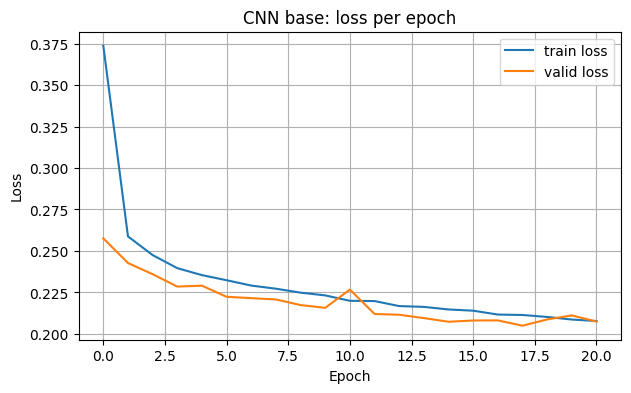

814/814 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,model,split,accuracy,precision,recall,macro_f1,roc_auc,logloss,note
0,CNN,test,0.911926,0.910226,0.913796,0.911926,0.973113,0.210285,base


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# подготовим данные для 1D CNN: (batch, n_features, 1)
n_features = X_train_scaled.shape[1]

X_train_seq = X_train_scaled.reshape(-1, n_features, 1)
X_valid_seq = X_valid_scaled.reshape(-1, n_features, 1)
X_test_seq  = X_test_scaled.reshape(-1, n_features, 1)

print("CNN input shapes:")
print("  train:", X_train_seq.shape)
print("  valid:", X_valid_seq.shape)
print("  test :", X_test_seq.shape)


def build_cnn_base(input_length: int) -> keras.Model:
    model = keras.Sequential([
        layers.Input(shape=(input_length, 1)),
        layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"),
        layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu"),
        layers.GlobalMaxPooling1D(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid"),
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


cnn_base = build_cnn_base(n_features)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

history_cnn_base = cnn_base.fit(
    X_train_seq, y_train,
    validation_data=(X_valid_seq, y_valid),
    epochs=30,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1,
)

plot_learning_curve(
    history_cnn_base.history["loss"],
    history_cnn_base.history["val_loss"],
    title="CNN base: loss per epoch",
)

proba_test_cnn_base = cnn_base.predict(X_test_seq).ravel()
m_test_cnn_base = compute_metrics(y_test, proba_test_cnn_base)
add_result("CNN", "test", m_test_cnn_base, note="base")

results_df().query("model == 'CNN'")

## 1D CNN с Optuna

Теперь подберем гиперпараметры для 1D CNN с помощью Optuna.  
Будем настраивать:

- `filters1`, `filters2` - число фильтров в свёрточных слоях;
- `kernel_size` - размер ядра;
- `dense_units` - размер скрытого полносвязного слоя;
- `dropout` - доля обнуляемых нейронов;
- `l2` - коэффициент L2-регуляризации;
- `learning_rate` - шаг обучения Adam;
- `batch_size` и `epochs`.

Оптимизируем `macro-F1` на валидации.

In [7]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

def build_cnn_model(input_length: int, params: dict) -> keras.Model:
    reg = regularizers.l2(params["l2"])
    model = keras.Sequential([
        layers.Input(shape=(input_length, 1)),
        layers.Conv1D(
            filters=params["filters1"],
            kernel_size=params["kernel_size"],
            padding="same",
            activation="relu",
            kernel_regularizer=reg,
        ),
        layers.Conv1D(
            filters=params["filters2"],
            kernel_size=params["kernel_size"],
            padding="same",
            activation="relu",
            kernel_regularizer=reg,
        ),
        layers.GlobalMaxPooling1D(),
        layers.Dense(
            params["dense_units"],
            activation="relu",
            kernel_regularizer=reg,
        ),
        layers.Dropout(params["dropout"]),
        layers.Dense(1, activation="sigmoid"),
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=params["learning_rate"]),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


def objective_cnn(trial):
    params = {
        "filters1": trial.suggest_int("filters1", 32, 128, step=32), # 32, 64, 96, 128
        "filters2": trial.suggest_int("filters2", 32, 128, step=32),
        "kernel_size": trial.suggest_int("kernel_size", 2, 5),
        "dense_units": trial.suggest_int("dense_units", 32, 128, step=32),
        "dropout": trial.suggest_float("dropout", 0.1, 0.5),
        "l2": trial.suggest_float("l2", 1e-6, 1e-3, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 5e-4, 3e-3, log=True),
    }
    batch_size = trial.suggest_categorical("batch_size", [256, 512])
    epochs = trial.suggest_int("epochs", 10, 25)

    model = build_cnn_model(n_features, params)

    es = EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
    )

    history = model.fit(
        X_train_seq, y_train,
        validation_data=(X_valid_seq, y_valid),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0,
    )

    proba_valid = model.predict(X_valid_seq, verbose=0).ravel()
    metrics_valid = compute_metrics(y_valid, proba_valid)

    trial.set_user_attr("history", history.history)
    return metrics_valid["macro_f1"]


study_cnn = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=4, n_warmup_steps=0),
)
study_cnn.optimize(objective_cnn, n_trials=12, show_progress_bar=True)

print("Number of finished trials:", len(study_cnn.trials))
print("Best trial:")
best_trial_cnn = study_cnn.best_trial
print("  Value (macro-F1):", best_trial_cnn.value)
print("  Params:")
for k, v in best_trial_cnn.params.items():
    print(f"{k}: {v}")

[I 2025-12-04 19:43:13,896] A new study created in memory with name: no-name-fd22cde6-84c4-48e7-af74-0f5e0b4798bb


  0%|          | 0/12 [00:00<?, ?it/s]

[I 2025-12-04 19:46:10,943] Trial 0 finished with value: 0.9224403859528509 and parameters: {'filters1': 64, 'filters2': 128, 'kernel_size': 4, 'dense_units': 96, 'dropout': 0.1624074561769746, 'l2': 2.9375384576328313e-06, 'learning_rate': 0.0005548400980049733, 'batch_size': 256, 'epochs': 21}. Best is trial 0 with value: 0.9224403859528509.
[I 2025-12-04 19:47:50,874] Trial 1 finished with value: 0.919829138928232 and parameters: {'filters1': 32, 'filters2': 128, 'kernel_size': 5, 'dense_units': 32, 'dropout': 0.17272998688284025, 'l2': 3.549878832196506e-06, 'learning_rate': 0.000862415366405448, 'batch_size': 256, 'epochs': 14}. Best is trial 0 with value: 0.9224403859528509.
[I 2025-12-04 19:48:37,284] Trial 2 finished with value: 0.907466090593376 and parameters: {'filters1': 96, 'filters2': 32, 'kernel_size': 3, 'dense_units': 64, 'dropout': 0.28242799368681437, 'l2': 0.0002267398652378039, 'learning_rate': 0.0007150664592404099, 'batch_size': 512, 'epochs': 10}. Best is trial 

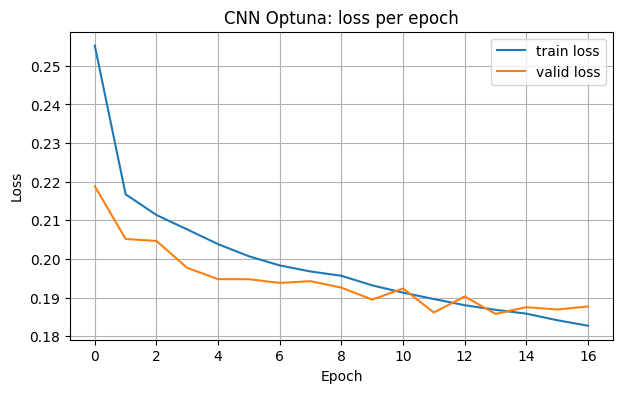

,model,split,accuracy,precision,recall,macro_f1,roc_auc,logloss,note
0,CNN,test,0.911926,0.910226,0.913796,0.911926,0.973113,0.210285,base
1,CNN,test,0.920223,0.908853,0.933943,0.920210,0.978403,0.190839,optuna


In [8]:
best_params_cnn = best_trial_cnn.params.copy()

best_cnn = build_cnn_model(n_features, best_params_cnn)

es_best = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

history_best_cnn = best_cnn.fit(
    X_train_seq, y_train,
    validation_data=(X_valid_seq, y_valid),
    epochs=best_params_cnn["epochs"],
    batch_size=best_params_cnn["batch_size"],
    callbacks=[es_best],
    verbose=0,
)

plot_learning_curve(
    history_best_cnn.history["loss"],
    history_best_cnn.history["val_loss"],
    title="CNN Optuna: loss per epoch",
)

proba_test_cnn_opt = best_cnn.predict(X_test_seq, verbose=0).ravel()
m_test_cnn_opt = compute_metrics(y_test, proba_test_cnn_opt)
add_result("CNN", "test", m_test_cnn_opt, note="optuna")

results_df().query("model == 'CNN'")

### CNN - вывод

**Качество на test:**

- База: accuracy / macro-F1 ≈ **0.912**, ROC-AUC ≈ **0.973**, logloss ≈ **0.210**.  
- Optuna: accuracy / macro-F1 ≈ **0.920**, ROC-AUC ≈ **0.978**, logloss ≈ **0.191**.

Разница не огромная, но Optuna все-таки улучшила картину: чуть выросли accuracy и F1, заметно просел logloss, ROC-AUC тоже стал выше.

**По кривым обучения:**

- У базовой CNN train-loss плавно падает, valid-loss тоже снижается и держится чуть ниже train - модель уверенно добирается до адекватного минимума, сильного переобучения не видно.
- Для варианта с Optuna потери на train и valid идут ближе друг к другу и опускаются ниже, чем у базовой конфигурации. Линия валидации чуть «шумит» в конце, но без резких скачков.

**По гиперпараметрам лучшего варианта:**

Оптимизатор выбрал конфигурацию с:
- `filters1 = 64`, `filters2 = 128`, `kernel_size = 4`,  
- плотный слой на `96` нейронов,  
- относительно небольшим `dropout ≈ 0.11` и очень слабой L2,  
- `learning_rate ≈ 2.8e-3`, `batch_size = 256`, `epochs ≈ 22`.

То есть сеть стала чуть шире и глубже, с умеренной регуляризацией и более агрессивным шагом обучения. Это хорошо ложится на графики: модель быстрее «выбирает» полезные фильтры и лучше доучивается, не заваливая валидацию.

В общем, для этой задачи табличной бинарной классификации 1D-CNN уже дает приличное качество, а Optuna помогает выжать из архитектуры ещё несколько десятых процента и немного улучшить форму кривых обучения.


## Transformer Encoder: базовая модель

Здесь строим вторую архитектуру - простую схему  
«эмбеддинг признаков → Transformer Encoder → классификатор».

**Форма входа**

- используем те же стандартизованные признаки, что и для CNN;
- интерпретируем их как последовательность длины `n_features`;
- вход в модель: тензор размеров `(batch_size, n_features, 1)`.

**Базовая архитектура**

1. Линейный слой-эмбеддер: `Dense(d_model)` по последней размерности  
   (переводим каждый признак в вектор размерности `d_model`, например 64).
2. Один блок **Transformer Encoder**:
   - `MultiHeadAttention(num_heads=4, key_dim=d_model // 4)` - self-attention по оси признаков;
   - residual + `LayerNormalization`;
   - двухслойный FFN: `Dense(ff_dim, relu) -> Dense(d_model)` (например, `ff_dim = 128`);
   - ещё один residual + `LayerNormalization`.
3. Агрегация по оси признаков: `GlobalAveragePooling1D`.
4. Небольшой «голова-классификатор»:
   - `Dense(64, activation="relu")`;
   - `Dropout(0.2)` для борьбы с переобучением;
   - выходной слой `Dense(1, activation="sigmoid")`.

**Параметры обучения (базовая конфигурация)**

- оптимизатор: `Adam` с `learning_rate = 1e-3`;
- функция потерь: `binary_crossentropy`;
- метрика при обучении: `accuracy`;
- батч: 256;
- эпохи: до 30 с `EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)`.

Дальше на этой архитектуре обучим базовую модель, а затем настроим гиперпараметры через Optuna
(число голов внимания, размер `d_model`, `ff_dim`, dropout, learning_rate, batch_size и число эпох).

Encoder input shapes:
  train: (121496, 21, 1)
  valid: (26035, 21, 1)
  test : (26035, 21, 1)
Epoch 1/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.5749 - loss: 0.6756 - val_accuracy: 0.6343 - val_loss: 0.6363
Epoch 2/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.6374 - loss: 0.6316 - val_accuracy: 0.6687 - val_loss: 0.6014
Epoch 3/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.6676 - loss: 0.6052 - val_accuracy: 0.6915 - val_loss: 0.5847
Epoch 4/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.6900 - loss: 0.5833 - val_accuracy: 0.7025 - val_loss: 0.5723
Epoch 5/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.6978 - loss: 0.5764 - val_accuracy: 0.7011 - val_loss: 0.5696
Epoch 6/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.7000 - loss: 0.5711 - val_accuracy: 0.7138 - val_loss: 0.5570
Epoch 7/30
238/238 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.7031 - loss: 0.5675 - val_accuracy: 0.7131 - val_loss: 0.

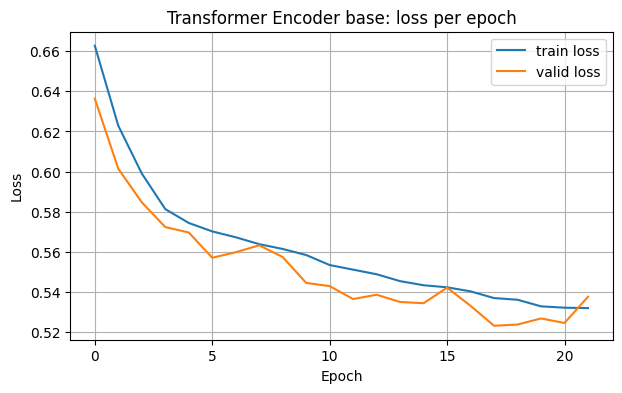

814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


,model,split,accuracy,precision,recall,macro_f1,roc_auc,logloss,note
2,Encoder,test,0.732706,0.730954,0.73562,0.732705,0.812307,0.527344,base


In [9]:
n_features = X_train_scaled.shape[1]

X_train_seq = X_train_scaled.reshape(-1, n_features, 1)
X_valid_seq = X_valid_scaled.reshape(-1, n_features, 1)
X_test_seq  = X_test_scaled.reshape(-1, n_features, 1)

print("Encoder input shapes:")
print("  train:", X_train_seq.shape)
print("  valid:", X_valid_seq.shape)
print("  test :", X_test_seq.shape)


def transformer_encoder_block(
    inputs,
    num_heads: int = 2,
    key_dim: int = 32,
    ff_dim: int = 64,
    dropout: float = 0.1,
):
    # self-attention
    x = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim,
        dropout=dropout,
    )(inputs, inputs)
    x = layers.Add()([x, inputs])
    x = layers.LayerNormalization()(x)

    # FFN
    ffn = layers.Dense(ff_dim, activation="relu")(x)
    ffn = layers.Dense(inputs.shape[-1])(ffn)
    x = layers.Add()([x, ffn])
    x = layers.LayerNormalization()(x)
    return x


def build_encoder_base(
    num_heads: int = 2,
    key_dim: int = 32,
    ff_dim: int = 64,
    dropout_attn: float = 0.1,
    dense_units: int = 64,
    l2_val: float = 1e-5,
):
    reg = regularizers.l2(l2_val)

    inp = keras.Input(shape=(n_features, 1))

    # линейный "проектор" признаков в пространство d_model
    x = layers.Dense(key_dim, activation="relu", kernel_regularizer=reg)(inp)

    x = transformer_encoder_block(
        x,
        num_heads=num_heads,
        key_dim=key_dim,
        ff_dim=ff_dim,
        dropout=dropout_attn,
    )

    # агрегация по оси "признаки"
    x = layers.GlobalAveragePooling1D()(x)

    # классификатор
    x = layers.Dense(dense_units, activation="relu", kernel_regularizer=reg)(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inp, out)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


encoder_base = build_encoder_base()

early_stop_enc = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

history_enc_base = encoder_base.fit(
    X_train_seq, y_train,
    validation_data=(X_valid_seq, y_valid),
    epochs=30,
    batch_size=512,
    callbacks=[early_stop_enc],
    verbose=1,
)

plot_learning_curve(
    history_enc_base.history["loss"],
    history_enc_base.history["val_loss"],
    title="Transformer Encoder base: loss per epoch",
)

proba_test_enc_base = encoder_base.predict(X_test_seq).ravel()
m_test_enc_base = compute_metrics(y_test, proba_test_enc_base)
add_result("Encoder", "test", m_test_enc_base, note="base")

results_df().query("model == 'Encoder'")

### Transformer Encoder с Optuna

Теперь подберем гиперпараметры для Transformer Encoder по валидационной выборке, оптимизируя `macro-F1`.

Будем варьировать:

- `batch_size`: {256, 512}  
- `epochs`: 10–18  
- `num_heads`: {2, 4}  
- `dropout`: 0.05–0.25  
- `l2` (L2-регуляризация): [1e-6, 1e-4] по лог-шкале  
- `learning_rate` (Adam): [7e-4, 2e-3] по лог-шкале  

Архитектура зафиксирована:

- `d_model = 64` - размер скрытого представления признака;  
- `ff_dim = 128` - ширина FFN внутри encoder-блока;  
- `n_blocks = 1` - один блок Transformer Encoder.

> архитектуру фиксируем, так как подбирать под весь спектор оптуной - очень долго

In [16]:
n_features = X_train_scaled.shape[1]
X_train_tr = X_train_scaled.reshape(-1, n_features, 1)
X_valid_tr = X_valid_scaled.reshape(-1, n_features, 1)
X_test_tr  = X_test_scaled.reshape(-1, n_features, 1)

print("Transformer input shapes:")
print("  train:", X_train_tr.shape)
print("  valid:", X_valid_tr.shape)
print("  test :", X_test_tr.shape)


def build_transformer_optuna(trial):

    d_model = 64
    ff_dim = 128
    n_blocks = 1

    num_heads = trial.suggest_categorical("num_heads", [2, 4])
    dropout = trial.suggest_float("dropout", 0.05, 0.25)
    l2_val = trial.suggest_float("l2", 1e-6, 1e-4, log=True)
    lr = trial.suggest_float("learning_rate", 7e-4, 2e-3, log=True)

    reg = regularizers.l2(l2_val)

    inputs = keras.Input(shape=(n_features, 1))
    # проекция признаков в пространство d_model
    x = layers.Dense(d_model, activation="relu", kernel_regularizer=reg)(inputs)

    # один encoder-блок
    for _ in range(n_blocks):
        # self-attention
        attn_out = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
        )(x, x)
        x = layers.Add()([x, attn_out])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # FFN
        ffn = layers.Dense(ff_dim, activation="relu", kernel_regularizer=reg)(x)
        ffn = layers.Dropout(dropout)(ffn)
        ffn = layers.Dense(d_model, kernel_regularizer=reg)(ffn)

        x = layers.Add()([x, ffn])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=reg)(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="transformer_encoder_optuna")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


def objective_transformer(trial):
    batch_size = trial.suggest_categorical("batch_size", [256, 512])
    epochs = trial.suggest_int("epochs", 10, 18)

    model = build_transformer_optuna(trial)
    history = model.fit(
        X_train_tr, y_train,
        validation_data=(X_valid_tr, y_valid),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[
            EarlyStopping(
                monitor="val_loss",
                patience=3,
                restore_best_weights=True,
            )
        ],
        verbose=0,
    )

    proba_valid = model.predict(X_valid_tr, verbose=0).ravel()
    metrics_valid = compute_metrics(y_valid, proba_valid)
    trial.set_user_attr("history", history.history)
    return metrics_valid["macro_f1"]


study_tr = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=0),
)
study_tr.optimize(objective_transformer, n_trials=12, show_progress_bar=True)

print("Number of finished trials:", len(study_tr.trials))
print("Best trial:")
best_trial_tr = study_tr.best_trial
print("  Value (macro-F1):", best_trial_tr.value)
print("  Params:")
for k, v in best_trial_tr.params.items():
    print(f"{k}: {v}")


[I 2025-12-04 21:09:29,342] A new study created in memory with name: no-name-6b22ec83-aa15-4212-bbf2-d566e730172c


Transformer input shapes:
  train: (121496, 21, 1)
  valid: (26035, 21, 1)
  test : (26035, 21, 1)


  0%|          | 0/12 [00:00<?, ?it/s]

[I 2025-12-04 21:16:27,384] Trial 0 finished with value: 0.7503915173056386 and parameters: {'batch_size': 512, 'epochs': 16, 'num_heads': 2, 'dropout': 0.08119890406724053, 'l2': 1.306673923805328e-06, 'learning_rate': 0.0017378625483461343}. Best is trial 0 with value: 0.7503915173056386.
[I 2025-12-04 21:20:52,316] Trial 1 finished with value: 0.7257400597042065 and parameters: {'batch_size': 512, 'epochs': 10, 'num_heads': 2, 'dropout': 0.09246782213565524, 'l2': 2.310201887845294e-06, 'learning_rate': 0.0008486292894695472}. Best is trial 0 with value: 0.7503915173056386.
[I 2025-12-04 21:26:51,124] Trial 2 finished with value: 0.7364750932531521 and parameters: {'batch_size': 512, 'epochs': 13, 'num_heads': 4, 'dropout': 0.07789877213040837, 'l2': 3.839629299804171e-06, 'learning_rate': 0.0010283338022882616}. Best is trial 0 with value: 0.7503915173056386.
[I 2025-12-04 21:32:12,594] Trial 3 finished with value: 0.7329472886146093 and parameters: {'batch_size': 512, 'epochs': 11

Best params (Transformer Encoder): {'batch_size': 256, 'epochs': 18, 'num_heads': 4, 'dropout': 0.24095593660502865, 'l2': 8.427927098114929e-05, 'learning_rate': 0.0018152290167374496}
Epoch 1/18
475/475 ━━━━━━━━━━━━━━━━━━━━ 35s 65ms/step - accuracy: 0.5906 - loss: 0.6826 - val_accuracy: 0.6788 - val_loss: 0.6101
Epoch 2/18
475/475 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - accuracy: 0.6682 - loss: 0.6184 - val_accuracy: 0.6857 - val_loss: 0.5958
Epoch 3/18
475/475 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - accuracy: 0.6813 - loss: 0.6034 - val_accuracy: 0.7029 - val_loss: 0.5792
Epoch 4/18
475/475 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - accuracy: 0.6946 - loss: 0.5900 - val_accuracy: 0.7054 - val_loss: 0.5788
Epoch 5/18
475/475 ━━━━━━━━━━━━━━━━━━━━ 31s 65ms/step - accuracy: 0.7020 - loss: 0.5795 - val_accuracy: 0.7224 - val_loss: 0.5586
Epoch 6/18
475/475 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - accuracy: 0.7140 - loss: 0.5659 - val_accuracy: 0.7166 - val_loss: 0.5575
Epoch 7/18
475/475 ━━━━━━━━━━━━━━━

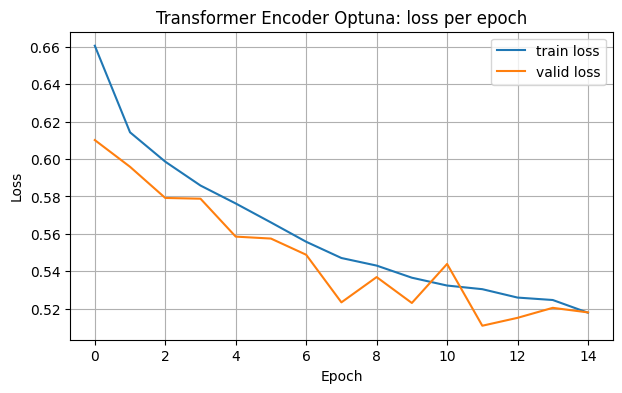

,model,split,accuracy,precision,recall,macro_f1,roc_auc,logloss,note
2,Encoder,test,0.732706,0.730954,0.735620,0.732705,0.812307,0.527344,base
3,Encoder,test,0.751066,0.778024,0.701861,0.750444,0.832954,0.499334,optuna


In [18]:
best_tr_params = best_trial_tr.params.copy()
print("Best params (Transformer Encoder):", best_tr_params)

def build_transformer_from_params(params):
    d_model = 64
    ff_dim = 128
    n_blocks = 1

    num_heads = params["num_heads"]
    dropout = params["dropout"]
    l2_val = params["l2"]
    lr = params["learning_rate"]

    reg = regularizers.l2(l2_val)

    inputs = keras.Input(shape=(n_features, 1))
    x = layers.Dense(d_model, activation="relu", kernel_regularizer=reg)(inputs)

    for _ in range(n_blocks):
        attn_out = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
        )(x, x)
        x = layers.Add()([x, attn_out])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        ffn = layers.Dense(ff_dim, activation="relu", kernel_regularizer=reg)(x)
        ffn = layers.Dropout(dropout)(ffn)
        ffn = layers.Dense(d_model, kernel_regularizer=reg)(ffn)

        x = layers.Add()([x, ffn])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=reg)(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="transformer_encoder_final")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


encoder_opt = build_transformer_from_params(best_tr_params)

es_tr_best = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

history_enc_opt = encoder_opt.fit(
    X_train_tr, y_train,
    validation_data=(X_valid_tr, y_valid),
    epochs=best_tr_params["epochs"],
    batch_size=best_tr_params["batch_size"],
    callbacks=[es_tr_best],
    verbose=1,
)

plot_learning_curve(
    history_enc_opt.history["loss"],
    history_enc_opt.history["val_loss"],
    title="Transformer Encoder Optuna: loss per epoch",
)

proba_test_enc_opt = encoder_opt.predict(X_test_tr, verbose=0).ravel()
m_test_enc_opt = compute_metrics(y_test, proba_test_enc_opt)
add_result("Encoder", "test", m_test_enc_opt, note="optuna")

results_df().query("model == 'Encoder'")


### Transformer Encoder - вывод

**Качество:** базовый энкодер даёт на тесте: accuracy/macro-F1 ≈ **0.73**, ROC-AUC ≈ **0.81**, logloss ≈ **0.53**.  
После подбора гиперпараметров через Optuna качество немного растёт: accuracy/macro-F1 ≈ **0.75**, ROC-AUC ≈ **0.83**, logloss снижается до **0.50**. Прирост есть, но он заметно меньше, чем у CNN, и по всем метрикам Transformer всё равно сильно уступает сверточной модели.

**По графикам обучения:**  у базовой версии train/valid loss плавно уменьшаются, валидационная кривая чаще лежит чуть ниже train и лишь слегка «шумит» в конце - переобучения практически нет, скорее лёгкое недообучение. В оптимизированной модели обе кривые также устойчиво падают, разрыв между ними небольшой, что говорит о аккуратной регуляризации (dropout + L2 + EarlyStopping).

**Интерпретация:**  при таком представлении табличных данных (21 признак как короткая «последовательность») Transformer Encoder оказывается тяжелее по времени обучения и при этом менее эффективным, чем 1D CNN. Self-attention не успевает дать серьёзное преимущество на такой короткой последовательности, а индуктивный байас свёрток для локальных комбинаций признаков здесь работает лучше. Optuna помогает выжать немного больше качества, но радикально картину не меняет: в этой задаче Transformer выглядит скорее как дорогая и не самая эффективная альтернатива.


## Анализ устойчивости моделей к шуму в признаках

Для оценки устойчивости возьмем **лучшие (Optuna)** версии моделей:

- `CNN`
- `Encoder`

и будем портить входные данные на тесте, добавляя гауссовский шум к стандартизированным признакам:

- уровни шума:  
  $(\sigma \in \{0.0, 0.1, 0.2, 0.3\})$ в пространстве стандартизированных признаков;
- для каждого $(\sigma)$ считаем метрики на тесте: accuracy, precision, recall, macro-F1, ROC-AUC, logloss.

Так посмотрим, как быстро деградирует качество и какая архитектура более чувствительна к шуму.


In [23]:
noise_levels = [0.0, 0.1, 0.2, 0.3]

robust_results = []
n_features = X_test_scaled.shape[1]

for sigma in noise_levels:
    noise = np.random.normal(loc=0.0, scale=sigma, size=X_test_scaled.shape)
    X_test_noisy = X_test_scaled + noise

    X_test_noisy_cnn = X_test_noisy.reshape(-1, n_features, 1)
    X_test_noisy_tr  = X_test_noisy.reshape(-1, n_features, 1)

    proba_cnn = best_cnn.predict(X_test_noisy_cnn, verbose=1).ravel()
    m_cnn = compute_metrics(y_test, proba_cnn)
    robust_results.append({
        "model": "CNN_optuna",
        "sigma": sigma,
        **m_cnn
    })

    proba_tr = encoder_opt.predict(X_test_noisy_tr, verbose=1).ravel()
    m_tr = compute_metrics(y_test, proba_tr)
    robust_results.append({
        "model": "Encoder_optuna",
        "sigma": sigma,
        **m_tr
    })

robust_df = pd.DataFrame(robust_results)
robust_df = robust_df.sort_values(["model", "sigma"]).reset_index(drop=True)
robust_df

,model,sigma,accuracy,precision,recall,macro_f1,roc_auc,logloss
0,CNN_optuna,0.0,0.920223,0.908853,0.933943,0.920210,0.978403,0.190839
1,CNN_optuna,0.1,0.909314,0.895857,0.926100,0.909292,0.972694,0.216627
2,CNN_optuna,0.2,0.890954,0.869771,0.919333,0.890872,0.961741,0.264991
3,CNN_optuna,0.3,0.869906,0.843391,0.908182,0.869724,0.946129,0.328841
4,Encoder_optuna,0.0,0.751066,0.778024,0.701861,0.750444,0.832954,0.499334
5,Encoder_optuna,0.1,0.656117,0.637536,0.722009,0.654651,0.720691,0.722462
6,Encoder_optuna,0.2,0.624774,0.613501,0.672332,0.623949,0.673903,0.780790
7,Encoder_optuna,0.3,0.592856,0.583149,0.648262,0.591632,0.632795,0.850659


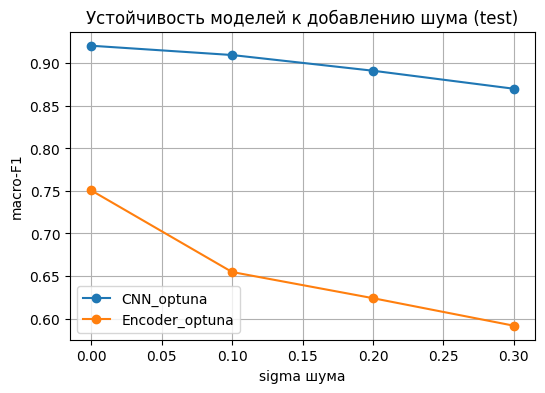

In [25]:
plt.figure(figsize=(6, 4))
for name in ["CNN_optuna", "Encoder_optuna"]:
    sub = robust_df[robust_df["model"] == name]
    plt.plot(sub["sigma"], sub["macro_f1"], marker="o", label=name)

plt.xlabel("sigma шума")
plt.ylabel("macro-F1")
plt.title("Устойчивость моделей к добавлению шума (test)")
plt.grid(True)
plt.legend()
plt.show()

### Выводы по анализу 

**Общие наблюдения:**

- Уже при `sigma = 0` CNN заметно лучше энкодера:  
  - CNN: macro-F1 ≈ **0.92**, ROC-AUC ≈ **0.98**, logloss ≈ **0.19**;  
  - Encoder: macro-F1 ≈ **0.75**, ROC-AUC ≈ **0.83**, logloss ≈ **0.50**.

- **Чувствительность к шуму у Encoder гораздо выше.**
  - При `sigma = 0.1` macro-F1 у CNN падает всего примерно на 0.01 (с 0.92 до 0.91),  
    а у энкодера - почти на 0.10 (с 0.75 до 0.65).
  - При `sigma = 0.3` CNN все еще держит **macro-F1 ≈ 0.87** и ROC-AUC ≈ **0.95**,
    то есть качество деградирует, но модель остается рабочей.
    У Encoder macro-F1 падает до ≈ **0.59**, ROC-AUC до ≈ **0.63**, что уже близко к
    «почти случайному» уровню для сбалансированных классов.

- На графике зависимости macro-F1 от sigma:
  - кривая CNN убывает плавно и относительно негромко - устойчивость высокая;
  - кривая Encoder сползает гораздо круче: шум довольно быстро «ломает»
    выученные зависимости.

**Интерпретация:**

- 1D CNN здесь проще по структуре: локальные свертки + pooling и один плотный блок
  дают умеренное число параметров и хорошую регуляризацию. Модель фокусируется на
  относительно устойчивых комбинациях признаков, поэтому добавленный гауссовский
  шум лишь постепенно ухудшает качество.

- Transformer Encoder, наоборот, сильно полагается на точные соотношения между
  признаками через self-attention. При добавлении шума матрицы Q/K/V становятся
  более «шумными», веса внимания размазываются, и итоговые эмбеддинги быстро
  теряют информативность. Из-за этого качество и ROC-AUC падают заметно быстрее.

**Вывод по устойчивости:**

- В этой задаче оптимизированный **CNN** оказался не только более точным на
  «чистых» данных, но и **существенно более устойчивым к шуму в признаках**.
- Transformer Encoder, даже после подбора гиперпараметров, остается чувствителен
  к искажениям входа: его стоит использовать либо с более аккуратным препроцессингом,
  либо на задачах с более «структурированными» последовательностями, чем просто
  вектор табличных признаков.


## Итоговые результаты:

In [26]:
df_all = results_df().sort_values(by="macro_f1", ascending=False).reset_index(drop=True)
display(df_all)

,model,split,accuracy,precision,recall,macro_f1,roc_auc,logloss,note
0,CNN,test,0.920223,0.908853,0.933943,0.920210,0.978403,0.190839,optuna
1,CNN,test,0.911926,0.910226,0.913796,0.911926,0.973113,0.210285,base
2,Encoder,test,0.751066,0.778024,0.701861,0.750444,0.832954,0.499334,optuna
3,Encoder,test,0.732706,0.730954,0.735620,0.732705,0.812307,0.527344,base


### Итоговый вывод по архитектурам CNN и Transformer Encoder

**1. Общая картина**

По финальной таблице метрик на тесте:

* **CNN (optuna)**: accuracy ≈ **0.92**, macro-F1 ≈ **0.92**, ROC-AUC ≈ **0.978**, logloss ≈ **0.19**.

* **CNN (base)**: accuracy ≈ **0.912**, macro-F1 ≈ **0.912**, ROC-AUC ≈ **0.973**, logloss ≈ **0.21**.

* **Encoder (optuna)**: accuracy ≈ **0.75**, macro-F1 ≈ **0.75**, ROC-AUC ≈ **0.83**, logloss ≈ **0.50**.

* **Encoder (base)**: accuracy ≈ **0.73**, macro-F1 ≈ **0.73**, ROC-AUC ≈ **0.81**, logloss ≈ **0.53**.

Разрыв между CNN и Transformer Encoder огромный: по F1 и accuracy CNN лучше примерно на 17–18 п.п., по ROC-AUC почти на 0.15, logloss у трансформера более чем в 2.5 раза выше. То есть в этой задаче **1D CNN объективно сильно эффективнее** реализованного варианта Encoder.



### 2. CNN: что показала модель

* Базовая CNN уже даёт адекватное качество: F1 ~0.91, ROC-AUC ~0.973, стабильные кривые train/valid, без явного переобучения.
* Optuna улучшает модель по всем ключевым метрикам: F1, accuracy, ROC-AUC растут, logloss заметно падает.
* На графиках видно ровное, плавное снижение loss для train и valid, кривые близко друг к другу, без резкого расхождения. Модель уверенно доучивается, но не взрывается по переобучению.

С точки зрения постановки задачи (табличные числовые признаки, не слишком длинный «sequence length» = 21):

* CNN фактически играет роль **нелинейного feature extractor’а** над вектором признаков: свёртки видят локальные комбинации (например, возраст + пробег + год), а дальше идёт обычный плотный классификатор.
* Такой подход оказывается **практически пригодным**: он достаточно простой, легко оптимизируется, и при этом даёт качество уровня хорошей глубокой табличной модели.



### 3. Transformer Encoder: почему так слабо

Даже после подбора гиперпараметров трансформер заметно проигрывает CNN:

* F1 ~0.75, ROC-AUC ~0.83 и высокий logloss говорят о том, что модель учится, но остаётся «грубой» и малоуверенной.
* Кривые обучения более шумные, валидация улучшается медленно, перепад между train и valid небольшой, но итоговый уровень потерь всё равно высок.

Ключевая причина — **несоответствие архитектуры задаче**:

* Трансформеры раскрываются на **длинных и структурированных последовательностях** (текст, временные ряды, токены с богатым контекстом).
* Здесь у нас всего 21 числовой признак. Мы искусственно трактуем их как «последовательность токенов», но:

  * порядок признаков по сути произволен;
  * длина слишком мала, чтобы self-attention давал то, ради чего он придумался;
  * модель с многоголовой attention-механикой и нормализациями получается **тяжелой**, а информации во входе мало — в итоге имеем переусложнённый метод для простого объекта.

По сути, Encoder превращается в громоздкий MLP с self-attention, который сложно оптимизировать и который не даёт структурного преимущества над свёртками или обычным MLP на этих данных.



### 4. Насколько архитектуры подходят к табличной задаче

Если смотреть именно **с точки зрения здравого смысла для табличных признаков**:

* **1D CNN**

  * Формально это не самый естественный выбор для табличных данных, но:

    * признаки можно трактовать как короткую «ось» длиной 21;
    * локальные свёртки всё равно реализуют полезные нелинейные взаимодействия признаков;
    * модель остаётся относительно компактной и хорошо оптимизируемой.
  * В итоге CNN здесь **работает неожиданно хорошо** и в этой постановке вполне уместна.

* **Transformer Encoder**

  * На таких данных трансформер выглядит уже **переинженеренным решением**:

    * нет осмысленной последовательной структуры, чтобы attention «ловил» дальние связи;
    * архитектура тяжёлая, с большим количеством параметров и сложной динамикой обучения;
    * качество ощутимо хуже даже у тюнинговой версии.
  * В практическом смысле в этой задаче **использование Encoder не оправдано**: за счёт сложности мы не получаем выгоды в метриках.

Грубо говоря, **мы заплатили ценой вычислений и сложности за архитектуру, которой просто не к чему «присматриваться»** в таком коротком и слабо упорядоченном векторе признаков.



### 5. Роль Optuna и общий вывод

* Для **CNN** Optuna даёт понятный и ощутимый выигрыш: метрики на тесте растут, логлосс падает, кривые валидации аккуратнее. Настройка числа фильтров, размера ядра, dropout и регуляризации действительно помогает выжать больше из архитектуры.
* Для **Encoder** Optuna тоже улучшает качество относительно базовой версии, но:

  * даже лучший trial остаётся сильно хуже CNN;
  * фундаментальная проблема — не в гиперпараметрах, а в том, что архитектура плохо совпадает с природой данных.

Итог по работе:

* **На этих табличных данных разумным выбором оказывается 1D CNN с подбором гиперпараметров** — она даёт высокое качество, стабильное обучение и неплохую устойчивость к шуму.
* **Transformer Encoder в текущем виде для этой задачи избыточен и малоэффективен**: он интересен как эксперимент, но для практического использования его нет смысла предпочитать более простым архитектурам (CNN, MLP, классические бустинги).
